# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

This solution is a trimmed down version of the notebook file provided for this project, edited to make it easier to follow my solution.

## Import Packages

In [8]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


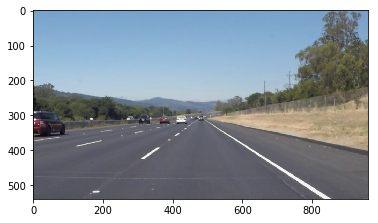

In [5]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Provided Helper Functions

Below are some helper functions provided by Udacity.

In [6]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines) # draw_lines(line_img, lines)----------------------------------------------
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [9]:
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

## Solution: New and Modified Helper Functions

In [41]:
# Helper function modified for extrapolation
def draw_lines_1(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    """
    
    left_grads = []
    left_Cs = []
    right_grads = []
    right_Cs = []
    
    for line in lines:
        # get m and c as in y=mx+c
        for x1,y1,x2,y2 in line:
            if x2==x1: # prevent NANs (divide by zero)
                pass
            else:
                # length = ((x1-x2)**2+(y1-y2)**2)**0.5
                grad = (y2-y1)/(x2-x1)
                C    = y1 - grad * x1
                
                #f length > 50:# ignore noise ### ??made obsolete by choice of average??
                # this conditional results in NANs for some reason

                # store grad and y-int according to left or right lane line
                # left lane - NB: y increases going DOWN image, but x as usual, so negative
                if grad < -0.3 and grad > -1.8: # remove outliers (+0.3<m<1.8)
                    left_grads.append(grad)
                    left_Cs.append(C)
                elif grad > 0.2 and grad < 1.8:
                    right_grads.append(grad)
                    right_Cs.append(C)

    # Find median c and m (median because robust to outliers ie screen reflection etc)
    # Actually, mean works better. Don't know why.
    m_left = np.median(left_grads)
    c_left = np.median(left_Cs)
    m_right = np.median(right_grads)
    c_right = np.median(right_Cs)
    
    # 540 down by 960 along;
    # Extrapolate left with exceptions   
    try:
        y_1 = 540
        x_1 = int((y_1-c_left)/(m_left)) # to prevent nan error see below too
    except:
        print("here 1 ", m_left, c_left)
        x_1 = 10
        y_1 = int(m_left * x_1 + c_left)
    try:
        y_2 = 320 
        x_2 = int((y_2-c_left)/(m_left))
    except:
        print("here 2 ", m_left, c_left)
        x_2 = 480 - 10
        y_2 = int(m_left * x_2 + c_left)
    cv2.line(img, (x_1, y_1), (x_2, y_2), color, thickness)
    
    # Extrapolate right with debugging  
    try:
        y_1 = 540
        x_1 = int((y_1-c_right)/(m_right)) 
    except:
        print("here 3 ", m_right, c_right)
        x_1 = 960 - 10
        y_1 = int(m_right * x_1 + c_right) # common break point if high Hough threshold
    try:
        y_2 = 320 ## soft-code here and above
        x_2 = int((y_2-c_right)/(m_right))
    except:
        print("here 4 ", m_right, c_right)
        x_2 = 480 + 10
        y_2 = int(m_right * x_2 + c_right)
    cv2.line(img, (x_1, y_1), (x_2, y_2), color, thickness)
    
def hough_lines_1(img, rho, theta, threshold, min_line_len, max_line_gap): # modified to call modified draw_lines()

    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_1(line_img, lines) # draw_lines(line_img, lines)----------------------------------------------
    return line_img

def darken(img, threshold=200, average=False):
    '''
    Keeps only pixels whose value exceeds threshold; in average=True, imposes less stringent condition by 
    combining filtered pixel values with input values. NB doesn't use 'lightness', just RBG raw values.
    '''
    mask = (img > threshold).astype(np.uint8)
    dark = img * mask
    if average:
        dark = np.median(np.array([img, dark]), axis=0)
    dark = np.asarray(dark).astype(np.uint8)
    return dark

def rgb_to_hsv(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return hsv

def yellow_filter(img):
    # define range of yellow color in HSV
    lower_yellow = np.array([20,100,100])
    upper_yellow = np.array([30,255,255])
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask_y = cv2.inRange(hsv, lower_yellow, upper_yellow)
    out = cv2.bitwise_and(img, img, mask=mask_y)
    return out
    
def white_filter(img):
    # define range of white color in HSV
    lower_white = np.array([0,0,200])
    upper_white = np.array([255,40,255])
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask_w = cv2.inRange(hsv, lower_white, upper_white)
    out = cv2.bitwise_and(img, img, mask=mask_w)
    return out

def w_y_filter(img): 
    y = yellow_filter(img)
    w = white_filter(img)
    out = cv2.bitwise_or(w, y)
    return out

def w_y_dark(img_1, img_2):
    temp = np.ones_like(img_2)
    temp[:,:,0] = img_1
    temp[:,:,1] = img_1
    temp[:,:,2] = img_1
    #img_1 = np.array(img_1).astype(np.uint8)
    
    out = cv2.bitwise_or(temp, img_2)
    return out
    

## Solution: Pipeline

In [42]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def find_lanes(img, plots= False):
    
    if plots==True:

        # Prep plots
        fig = plt.figure(figsize=(15,10))

        # 0 Plot original
        a = fig.add_subplot(4,4,1)
        plt.imshow(img)
        a.set_title('original')
    
    # 0 Convert to HSV - NB pltting shows no change; beware passing this output to fns "expecting" rgb
    out_0 = rgb_to_hsv(img) # returns hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    if plots==True:
        a = fig.add_subplot(4,4,2)
        plt.imshow(out_0)
        a.set_title('hsv') 
        
    # 0_1 Extract yellow
    out_0_1 = yellow_filter(img) # these 3 functions take RGB inputs and convert internally...
    if plots==True:
        a = fig.add_subplot(4,4,3)
        plt.imshow(out_0_1)
        a.set_title('yellow')  
        
    # 0_2 Extract White
    out_0_2 = white_filter(img) # 
    if plots==True:
        a = fig.add_subplot(4,4,4)
        plt.imshow(out_0_2)
        a.set_title('white')   
        
    # 0_3 Apply both filters to original (OR)
    out_0_3 = w_y_filter(img)
    if plots==True:
        a = fig.add_subplot(4,4,5)
        plt.imshow(out_0_3)
        a.set_title('yellow & white')
        
    # 1 Grayscale
    out_1 = grayscale(img) # NB takes original image as input (not previous output)
    gray = out_1
    if plots==True:
        a = fig.add_subplot(4,4,6)
        plt.imshow(gray, cmap='gray')
        a.set_title('gray')
        
    # 1.1 Darken
    out_1_1 = darken(out_1, threshold=150, average=False) # (200, True) better than (150, False); (175,F) fails
    if plots==True:
        a = fig.add_subplot(4,4,7)
        plt.imshow(out_1_1)
        a.set_title('darken')
        
    # 1.2 Filter (yellow-white OR darken)
    out_1_2 = w_y_dark(out_1_1,  out_0_3)
    if plots==True:
        a = fig.add_subplot(4,4,8)
        plt.imshow(out_1_2)
        a.set_title('dark OR y-w')
        
    # 2 Gaussian blur
    kernel_size = 3 # Odd
    out_2 = gaussian_blur(out_1_2, kernel_size)
    if plots==True:
        a = fig.add_subplot(4,4,9)
        plt.imshow(out_2)
        a.set_title('blur')
        
    # 3 Canny transform
    low_threshold, high_threshold = (100,200) # (60, 150) works quite well; (40,130) no help
    out_3 = canny(out_2, low_threshold, high_threshold)
    edges = out_2
    if plots==True:
        a = fig.add_subplot(4,4,10)
        plt.imshow(out_3)
        a.set_title('Canny')

    # 4 Select region of interest
    imshape = image.shape
    vertices = np.array([[(imshape[1]*0.09,imshape[0]),
                        (imshape[1]*0.49, imshape[0]/2*1.14), 
                        (imshape[1]*0.51, imshape[0]/2*1.14),
                        (imshape[1]*0.91,imshape[0])]], 
                        dtype=np.int32)
    out_4 = region_of_interest(out_3, vertices)
    masked_edges = out_4
    if plots==True:
        a = fig.add_subplot(4,4,11)
        plt.imshow(out_4)
        a.set_title('region')
    
    # 5 Hough lines
    
    try:
        rho, theta, threshold = (1, np.pi/180, 100) # (1, np.pi/180, 1) 100 works but generates nans, 10 good both
        min_line_length, max_line_gap = (50, 50)  # (5,1)
        out_5 = hough_lines_1(out_4, rho, theta, threshold, min_line_length, max_line_gap)
    except:
        try:
            rho, theta, threshold = (1, np.pi/180, 30) # (1, np.pi/180, 1) 100 works but generates nans, 10 good both
            min_line_length, max_line_gap = (15, 50)  # (5,1)
            out_5 = hough_lines_1(out_4, rho, theta, threshold, min_line_length, max_line_gap)
        except:
            rho, theta, threshold = (1, np.pi/180, 10) # 1 for median=False?
            min_line_length, max_line_gap = (5, 50)  # (5,1)
            out_5 = hough_lines_1(out_4, rho, theta, threshold, min_line_length, max_line_gap)            
    if plots==True:
        a = fig.add_subplot(4,4,12)
        plt.imshow(out_5)
        a.set_title('alt Hough')
    
    # 6 Add to original
    out_6 = weighted_img(out_5, img, 0.8, 1, 0)
    if plots==True:
        a = fig.add_subplot(4,4,13)
        plt.imshow(out_6)
        a.set_title('output')

    # Adjust plots
    plt.tight_layout()
        
    return out_6    # needed for video but not for stills

array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

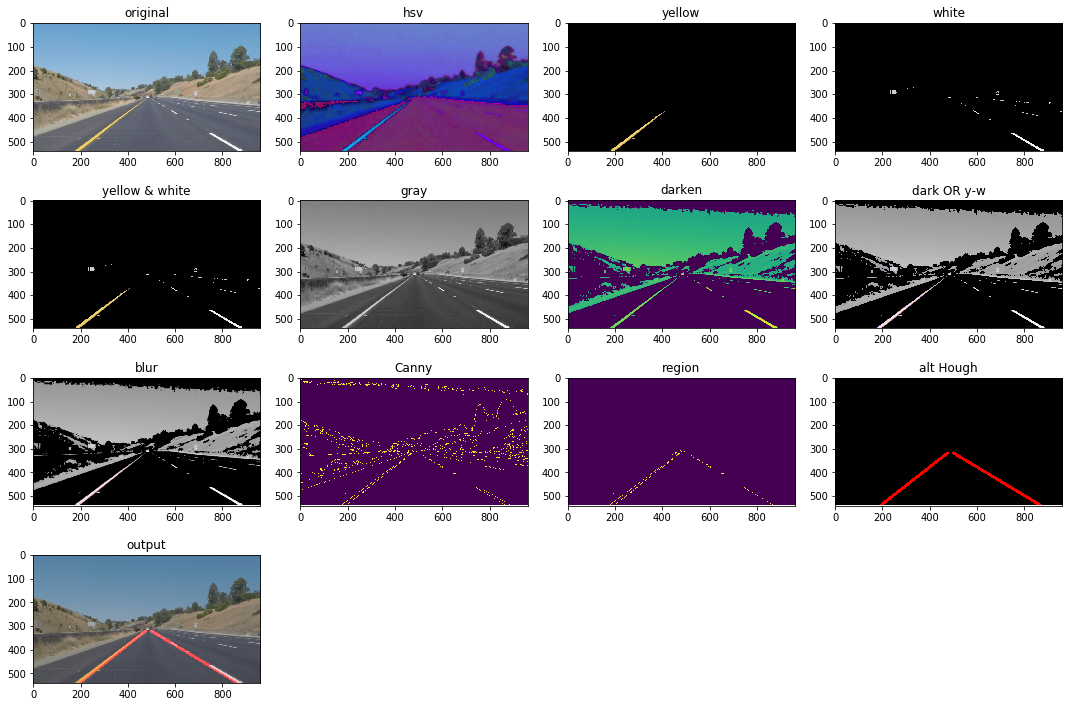

In [43]:
# test_image = image = mpimg.imread('test_images/solidWhiteRight.jpg')
images = os.listdir("test_images/")
test_image = mpimg.imread('test_images/'+str(images[1]))
find_lanes(test_image, plots=True)

## Test on Videos

In [20]:
def process_image(image):
    result = find_lanes(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [38]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  4%|▎         | 8/222 [00:00<00:14, 14.67it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan
here 1  nan nan



  5%|▌         | 12/222 [00:00<00:13, 15.22it/s]

here 1  nan nan
here 1  nan nan



  9%|▉         | 20/222 [00:01<00:12, 16.08it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan
here 1  nan nan



 11%|█         | 24/222 [00:01<00:12, 16.37it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 14%|█▎        | 30/222 [00:01<00:12, 14.82it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 15%|█▌        | 34/222 [00:02<00:12, 15.38it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan
here 1  nan nan



 17%|█▋        | 38/222 [00:02<00:11, 16.29it/s]

here 1  nan nan



 19%|█▉        | 42/222 [00:02<00:10, 16.65it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan
here 1  nan nan



 21%|██        | 46/222 [00:02<00:12, 14.51it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 24%|██▍       | 54/222 [00:03<00:13, 12.68it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 26%|██▌       | 58/222 [00:03<00:12, 12.68it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 27%|██▋       | 60/222 [00:04<00:12, 12.85it/s]

here 1  nan nan



 30%|██▉       | 66/222 [00:04<00:12, 12.20it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 31%|███       | 68/222 [00:04<00:12, 12.20it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 32%|███▏      | 72/222 [00:05<00:12, 11.92it/s]

here 1  nan nan



 35%|███▌      | 78/222 [00:05<00:11, 12.08it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 37%|███▋      | 82/222 [00:05<00:11, 11.67it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 38%|███▊      | 84/222 [00:06<00:11, 12.12it/s]

here 1  nan nan



 41%|████      | 90/222 [00:06<00:10, 12.27it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 42%|████▏     | 94/222 [00:06<00:10, 12.14it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 46%|████▌     | 102/222 [00:07<00:09, 12.92it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 48%|████▊     | 106/222 [00:07<00:09, 12.18it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 49%|████▊     | 108/222 [00:08<00:09, 11.99it/s]

here 1  nan nan



 51%|█████▏    | 114/222 [00:08<00:08, 12.98it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 53%|█████▎    | 118/222 [00:08<00:08, 12.57it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 54%|█████▍    | 120/222 [00:08<00:08, 12.62it/s]

here 1  nan nan



 57%|█████▋    | 126/222 [00:09<00:07, 12.81it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 59%|█████▊    | 130/222 [00:09<00:07, 12.49it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 59%|█████▉    | 132/222 [00:09<00:07, 12.02it/s]

here 1  nan nan



 62%|██████▏   | 138/222 [00:10<00:07, 11.98it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 64%|██████▍   | 142/222 [00:10<00:06, 11.51it/s]

here 1  nan nan
here 1  nan nan



 68%|██████▊   | 150/222 [00:11<00:05, 12.34it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 69%|██████▉   | 154/222 [00:11<00:05, 12.09it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 71%|███████   | 158/222 [00:12<00:05, 12.76it/s]

here 1  nan nan



 73%|███████▎  | 162/222 [00:12<00:04, 13.09it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 75%|███████▍  | 166/222 [00:12<00:04, 12.73it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 76%|███████▌  | 168/222 [00:12<00:04, 13.18it/s]

here 1  nan nan



 78%|███████▊  | 174/222 [00:13<00:03, 12.31it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 80%|████████  | 178/222 [00:13<00:03, 11.83it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 81%|████████  | 180/222 [00:13<00:03, 11.68it/s]

here 1  nan nan
here 1  nan nan



 84%|████████▍ | 186/222 [00:14<00:03, 10.87it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 86%|████████▌ | 190/222 [00:14<00:02, 11.21it/s]

here 1  nan nan
here 3  nan nan



 86%|████████▋ | 192/222 [00:15<00:02, 10.67it/s]

here 3  nan nan



 89%|████████▉ | 198/222 [00:15<00:02, 11.17it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 91%|█████████ | 202/222 [00:15<00:01, 11.66it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 92%|█████████▏| 204/222 [00:16<00:01, 11.37it/s]

here 1  nan nan
here 1  nan nan



 94%|█████████▎| 208/222 [00:16<00:01, 11.90it/s]

here 3  nan nan
here 3  nan nan



 95%|█████████▌| 212/222 [00:16<00:00, 11.68it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



 97%|█████████▋| 216/222 [00:17<00:00, 11.76it/s]

here 1  nan nan
here 1  nan nan
here 1  nan nan



100%|█████████▉| 221/222 [00:17<00:00, 12.65it/s]

here 1  nan nan
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 33.5 s, sys: 372 ms, total: 33.8 s
Wall time: 18.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [30]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds

##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  1%|          | 8/682 [00:00<00:43, 15.49it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan
here 3  nan nan



  1%|▏         | 10/682 [00:00<00:45, 14.71it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan
here 3  nan nan



  2%|▏         | 16/682 [00:01<00:42, 15.66it/s]

here 3  nan nan
here 3  nan nan



  3%|▎         | 20/682 [00:01<00:40, 16.20it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan
here 3  nan nan



  4%|▎         | 24/682 [00:01<00:41, 15.68it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan
here 3  nan nan



  4%|▍         | 30/682 [00:01<00:40, 16.18it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan
here 3  nan nan



  5%|▍         | 34/682 [00:02<00:42, 15.18it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan
here 3  nan nan



  6%|▌         | 38/682 [00:02<00:42, 15.19it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



  6%|▋         | 44/682 [00:02<00:43, 14.66it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



  7%|▋         | 46/682 [00:03<00:45, 14.00it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



  7%|▋         | 50/682 [00:03<00:49, 12.82it/s]

here 3  nan nan
here 3  nan nan



  8%|▊         | 56/682 [00:03<00:52, 11.94it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



  9%|▊         | 58/682 [00:04<00:53, 11.61it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



  9%|▉         | 62/682 [00:04<00:52, 11.79it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 10%|█         | 70/682 [00:05<00:53, 11.37it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 11%|█         | 72/682 [00:05<00:53, 11.48it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 11%|█         | 76/682 [00:05<00:50, 12.11it/s]

here 3  nan nan
here 3  nan nan



 12%|█▏        | 82/682 [00:06<00:49, 12.05it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 12%|█▏        | 84/682 [00:06<00:50, 11.76it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 13%|█▎        | 88/682 [00:06<00:49, 11.95it/s]

here 3  nan nan



 14%|█▍        | 94/682 [00:07<00:50, 11.68it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 14%|█▍        | 98/682 [00:07<00:47, 12.18it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 15%|█▍        | 100/682 [00:07<00:47, 12.29it/s]

here 3  nan nan



 16%|█▌        | 106/682 [00:08<00:47, 12.21it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 16%|█▌        | 110/682 [00:08<00:46, 12.18it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 16%|█▋        | 112/682 [00:08<00:47, 12.08it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 18%|█▊        | 120/682 [00:09<00:44, 12.61it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 18%|█▊        | 124/682 [00:09<00:47, 11.81it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 18%|█▊        | 126/682 [00:09<00:47, 11.72it/s]

here 3  nan nan



 19%|█▉        | 132/682 [00:10<01:00,  9.12it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 20%|█▉        | 136/682 [00:10<00:53, 10.22it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 20%|██        | 138/682 [00:10<00:51, 10.47it/s]

here 3  nan nan



 21%|██▏       | 146/682 [00:11<00:45, 11.79it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 22%|██▏       | 148/682 [00:11<00:45, 11.61it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 22%|██▏       | 152/682 [00:12<00:44, 11.91it/s]

here 3  nan nan
here 3  nan nan



 23%|██▎       | 158/682 [00:12<00:44, 11.65it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 23%|██▎       | 160/682 [00:12<00:45, 11.37it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 24%|██▍       | 164/682 [00:13<00:43, 11.87it/s]

here 3  nan nan



 25%|██▍       | 170/682 [00:13<00:41, 12.38it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 25%|██▌       | 172/682 [00:13<00:41, 12.36it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 26%|██▌       | 176/682 [00:14<00:42, 12.04it/s]

here 3  nan nan



 27%|██▋       | 182/682 [00:14<00:39, 12.52it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 27%|██▋       | 186/682 [00:14<00:39, 12.49it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 28%|██▊       | 194/682 [00:15<00:38, 12.60it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 29%|██▉       | 198/682 [00:15<00:38, 12.59it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 30%|███       | 208/682 [00:16<00:38, 12.33it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 31%|███       | 210/682 [00:16<00:36, 12.79it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 32%|███▏      | 220/682 [00:17<00:36, 12.67it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 33%|███▎      | 224/682 [00:17<00:37, 12.06it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 34%|███▍      | 232/682 [00:18<00:36, 12.41it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 35%|███▍      | 236/682 [00:18<00:37, 12.01it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 35%|███▍      | 238/682 [00:19<00:38, 11.44it/s]

here 3  nan nan



 36%|███▌      | 244/682 [00:19<00:37, 11.54it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 36%|███▋      | 248/682 [00:19<00:37, 11.64it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 37%|███▋      | 250/682 [00:20<00:34, 12.38it/s]

here 3  nan nan



 38%|███▊      | 258/682 [00:20<00:34, 12.12it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 38%|███▊      | 262/682 [00:21<00:34, 12.15it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 39%|███▊      | 264/682 [00:21<00:35, 11.72it/s]

here 3  nan nan
here 3  nan nan



 40%|███▉      | 272/682 [00:21<00:32, 12.50it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 40%|████      | 274/682 [00:22<00:34, 11.93it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 41%|████      | 278/682 [00:22<00:33, 11.97it/s]

here 3  nan nan



 41%|████▏     | 282/682 [00:22<00:33, 11.89it/s]

here 3  nan nan
here 3  nan nan



 42%|████▏     | 284/682 [00:22<00:34, 11.69it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 42%|████▏     | 286/682 [00:23<00:34, 11.58it/s]

here 3  nan nan
here 3  nan nan



 43%|████▎     | 296/682 [00:24<00:34, 11.35it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 44%|████▎     | 298/682 [00:24<00:32, 11.69it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 44%|████▍     | 302/682 [00:24<00:31, 11.90it/s]

here 3  nan nan
here 3  nan nan



 45%|████▌     | 308/682 [00:24<00:30, 12.08it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 46%|████▌     | 312/682 [00:25<00:31, 11.93it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 47%|████▋     | 320/682 [00:25<00:28, 12.80it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 48%|████▊     | 324/682 [00:26<00:28, 12.58it/s]

here 3  nan nan
here 3  nan nan



 49%|████▊     | 332/682 [00:26<00:26, 13.08it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 49%|████▉     | 336/682 [00:27<00:27, 12.44it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 50%|█████     | 344/682 [00:27<00:27, 12.08it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 51%|█████     | 348/682 [00:28<00:27, 12.01it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 51%|█████▏    | 350/682 [00:28<00:28, 11.60it/s]

here 3  nan nan



 52%|█████▏    | 356/682 [00:28<00:26, 12.18it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 53%|█████▎    | 360/682 [00:29<00:26, 11.96it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 53%|█████▎    | 362/682 [00:29<00:26, 12.12it/s]

here 3  nan nan
here 3  nan nan



 54%|█████▍    | 368/682 [00:29<00:25, 12.46it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 55%|█████▍    | 372/682 [00:30<00:25, 12.33it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 55%|█████▍    | 374/682 [00:30<00:24, 12.48it/s]

here 3  nan nan



 56%|█████▌    | 382/682 [00:31<00:24, 12.33it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 56%|█████▋    | 384/682 [00:31<00:25, 11.89it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 57%|█████▋    | 388/682 [00:31<00:23, 12.32it/s]

here 3  nan nan



 58%|█████▊    | 394/682 [00:31<00:23, 12.19it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 58%|█████▊    | 396/682 [00:32<00:24, 11.75it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 60%|█████▉    | 406/682 [00:32<00:21, 12.76it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 60%|█████▉    | 408/682 [00:33<00:21, 12.51it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 61%|██████▏   | 418/682 [00:33<00:21, 12.39it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 62%|██████▏   | 420/682 [00:34<00:22, 11.87it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 62%|██████▏   | 424/682 [00:34<00:21, 12.24it/s]

here 3  nan nan



 63%|██████▎   | 430/682 [00:34<00:21, 11.97it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 63%|██████▎   | 432/682 [00:35<00:20, 12.17it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 64%|██████▍   | 436/682 [00:35<00:19, 12.42it/s]

here 3  nan nan
here 3  nan nan



 65%|██████▍   | 442/682 [00:35<00:18, 13.07it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 65%|██████▌   | 444/682 [00:36<00:18, 12.97it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 66%|██████▌   | 448/682 [00:36<00:18, 12.35it/s]

here 3  nan nan
here 3  nan nan



 67%|██████▋   | 456/682 [00:37<00:18, 12.34it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 67%|██████▋   | 458/682 [00:37<00:18, 12.08it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 68%|██████▊   | 462/682 [00:37<00:17, 12.56it/s]

here 3  nan nan



 69%|██████▊   | 468/682 [00:37<00:17, 12.35it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 69%|██████▉   | 470/682 [00:38<00:17, 12.01it/s]

here 3  nan nan
here 3  nan nan



 70%|███████   | 480/682 [00:38<00:16, 11.92it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 71%|███████   | 482/682 [00:39<00:17, 11.74it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 71%|███████   | 484/682 [00:39<00:16, 11.76it/s]

here 3  nan nan



 72%|███████▏  | 492/682 [00:40<00:17, 11.15it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 72%|███████▏  | 494/682 [00:40<00:15, 11.75it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 73%|███████▎  | 498/682 [00:40<00:14, 12.41it/s]

here 3  nan nan



 74%|███████▍  | 504/682 [00:41<00:14, 12.14it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 74%|███████▍  | 508/682 [00:41<00:14, 12.33it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 76%|███████▌  | 516/682 [00:42<00:13, 12.29it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 76%|███████▌  | 520/682 [00:42<00:13, 11.85it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 77%|███████▋  | 526/682 [00:42<00:13, 11.89it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 78%|███████▊  | 530/682 [00:43<00:13, 11.33it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 78%|███████▊  | 534/682 [00:43<00:12, 11.65it/s]

here 3  nan nan
here 3  nan nan



 79%|███████▉  | 542/682 [00:44<00:11, 12.48it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 80%|███████▉  | 544/682 [00:44<00:11, 12.16it/s]

here 3  nan nan
here 3  nan nan



 80%|████████  | 548/682 [00:44<00:10, 12.52it/s]

here 3  nan nan



 81%|████████  | 552/682 [00:45<00:10, 12.56it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 82%|████████▏ | 556/682 [00:45<00:10, 11.78it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 82%|████████▏ | 558/682 [00:45<00:10, 11.61it/s]

here 3  nan nan
here 3  nan nan



 83%|████████▎ | 566/682 [00:46<00:09, 12.06it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 83%|████████▎ | 568/682 [00:46<00:09, 11.43it/s]

here 3  nan nan
here 3  nan nan



 84%|████████▍ | 572/682 [00:46<00:09, 11.16it/s]

here 3  nan nan



 85%|████████▍ | 578/682 [00:47<00:08, 11.68it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 85%|████████▌ | 582/682 [00:47<00:08, 11.48it/s]

here 3  nan nan
here 3  nan nan



 87%|████████▋ | 592/682 [00:48<00:07, 12.26it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 87%|████████▋ | 594/682 [00:48<00:07, 11.79it/s]

here 3  nan nan
here 3  nan nan



 89%|████████▊ | 604/682 [00:49<00:06, 12.36it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 89%|████████▉ | 606/682 [00:49<00:06, 12.30it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 90%|█████████ | 616/682 [00:50<00:05, 12.91it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 91%|█████████ | 618/682 [00:50<00:05, 12.28it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 91%|█████████ | 622/682 [00:50<00:05, 11.82it/s]

here 3  nan nan



 91%|█████████▏| 624/682 [00:51<00:04, 11.73it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 92%|█████████▏| 628/682 [00:51<00:04, 11.60it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 92%|█████████▏| 630/682 [00:51<00:04, 11.53it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 93%|█████████▎| 634/682 [00:51<00:04, 11.51it/s]

here 3  nan nan
here 3  nan nan



 94%|█████████▎| 638/682 [00:52<00:03, 11.65it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 94%|█████████▍| 642/682 [00:52<00:03, 11.12it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 94%|█████████▍| 644/682 [00:52<00:03, 10.92it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 95%|█████████▌| 648/682 [00:53<00:03, 11.05it/s]

here 3  nan nan



 96%|█████████▌| 652/682 [00:53<00:02, 11.32it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 96%|█████████▌| 656/682 [00:53<00:02, 11.38it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 96%|█████████▋| 658/682 [00:54<00:02, 11.51it/s]

here 3  nan nan



 98%|█████████▊| 666/682 [00:54<00:01, 11.91it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 98%|█████████▊| 668/682 [00:54<00:01, 11.34it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan


 98%|█████████▊| 670/682 [00:55<00:01, 11.11it/s]


 99%|█████████▉| 678/682 [00:55<00:00, 11.37it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



100%|█████████▉| 680/682 [00:55<00:00, 11.05it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



100%|█████████▉| 681/682 [00:56<00:00, 12.14it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1min 43s, sys: 1.98 s, total: 1min 45s
Wall time: 57.1 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [39]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds


##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

here 3  nan nan
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



  0%|          | 1/251 [00:00<00:30,  8.32it/s]

here 3  nan nan



  1%|          | 2/251 [00:00<00:29,  8.32it/s]

here 3  nan nan



  1%|          | 3/251 [00:00<00:29,  8.39it/s]

here 3  nan nan



  2%|▏         | 4/251 [00:00<00:29,  8.51it/s]

here 3  nan nan



  2%|▏         | 5/251 [00:00<00:28,  8.70it/s]

here 3  nan nan



  2%|▏         | 6/251 [00:00<00:28,  8.50it/s]

here 3  nan nan



  3%|▎         | 7/251 [00:00<00:30,  8.11it/s]

here 3  nan nan



  3%|▎         | 8/251 [00:00<00:31,  7.68it/s]

here 3  nan nan



  4%|▎         | 9/251 [00:01<00:30,  7.89it/s]

here 3  nan nan


here 3  nan nan
here 3  nan nan



  5%|▌         | 13/251 [00:01<00:27,  8.75it/s]

here 3  nan nan
here 3  nan nan



  6%|▌         | 15/251 [00:01<00:26,  8.90it/s]

here 3  nan nan
here 3  nan nan



  7%|▋         | 17/251 [00:01<00:26,  8.98it/s]

here 3  nan nan
here 3  nan nan



  8%|▊         | 19/251 [00:02<00:25,  9.08it/s]

here 3  nan nan
here 3  nan nan



  8%|▊         | 21/251 [00:02<00:24,  9.24it/s]

here 3  nan nan
here 3  nan nan



  9%|▉         | 23/251 [00:02<00:24,  9.20it/s]

here 3  nan nan
here 3  nan nan



 10%|▉         | 25/251 [00:02<00:24,  9.20it/s]

here 1  nan nan
here 3  nan nan



 10%|█         | 26/251 [00:02<00:24,  9.04it/s]

here 3  nan nan
here 3  nan nan



 12%|█▏        | 31/251 [00:03<00:23,  9.45it/s]

here 3  nan nan
here 3  nan nan



 13%|█▎        | 33/251 [00:03<00:23,  9.41it/s]

here 3  nan nan
here 3  nan nan



 14%|█▍        | 35/251 [00:03<00:24,  8.94it/s]

here 3  nan nan
here 3  nan nan



 15%|█▌        | 38/251 [00:04<00:22,  9.35it/s]

here 3  nan nan
here 3  nan nan



 16%|█▌        | 40/251 [00:04<00:22,  9.38it/s]

here 3  nan nan
here 3  nan nan



 17%|█▋        | 42/251 [00:04<00:21,  9.62it/s]

here 3  nan nan
here 3  nan nan



 18%|█▊        | 44/251 [00:04<00:26,  7.74it/s]

here 3  nan nan
here 3  nan nan



 18%|█▊        | 46/251 [00:05<00:26,  7.65it/s]

here 3  nan nan
here 3  nan nan
here 3  nan nan



 19%|█▉        | 48/251 [00:05<00:27,  7.40it/s]

here 3  nan nan
here 3  nan nan



 20%|█▉        | 50/251 [00:05<00:27,  7.37it/s]

here 3  nan nan
here 3  nan nan



 21%|██        | 52/251 [00:06<00:29,  6.77it/s]

here 3  nan nan
here 3  nan nan



 21%|██        | 53/251 [00:06<00:28,  6.86it/s]

here 3  nan nan
here 3  nan nan



 22%|██▏       | 56/251 [00:06<00:31,  6.24it/s]

here 3  nan nan
here 3  nan nan



 24%|██▎       | 59/251 [00:07<00:27,  6.93it/s]

here 3  nan nan
here 3  nan nan



 24%|██▍       | 61/251 [00:07<00:26,  7.19it/s]

here 3  nan nan
here 3  nan nan



 25%|██▌       | 63/251 [00:07<00:27,  6.84it/s]

here 3  nan nan
here 3  nan nan



 26%|██▌       | 65/251 [00:08<00:27,  6.75it/s]

here 3  nan nan
here 3  nan nan



 26%|██▋       | 66/251 [00:08<00:28,  6.55it/s]

here 3  nan nan
here 3  nan nan



 28%|██▊       | 70/251 [00:08<00:29,  6.13it/s]

here 3  nan nan
here 1  nan nan



 29%|██▊       | 72/251 [00:09<00:26,  6.88it/s]

here 3  nan nan
here 3  nan nan



 29%|██▉       | 74/251 [00:09<00:25,  7.07it/s]

here 3  nan nan
here 3  nan nan



 30%|███       | 76/251 [00:09<00:23,  7.39it/s]

here 3  nan nan
here 3  nan nan



 31%|███       | 77/251 [00:09<00:25,  6.72it/s]

here 3  nan nan
here 3  nan nan



 32%|███▏      | 80/251 [00:10<00:26,  6.53it/s]

here 3  nan nan
here 3  nan nan



 33%|███▎      | 82/251 [00:10<00:26,  6.44it/s]

here 3  nan nan
here 1  nan nan



 33%|███▎      | 84/251 [00:10<00:25,  6.68it/s]

here 1  nan nan
here 1  nan nan



 34%|███▍      | 86/251 [00:11<00:24,  6.82it/s]

here 1  nan nan
here 1  nan nan



 35%|███▌      | 88/251 [00:11<00:24,  6.61it/s]

here 1  nan nan
here 1  nan nan



 36%|███▌      | 90/251 [00:11<00:24,  6.69it/s]

here 1  nan nan
here 1  nan nan



 37%|███▋      | 92/251 [00:12<00:24,  6.38it/s]

here 1  nan nan
here 1  nan nan



 37%|███▋      | 94/251 [00:12<00:25,  6.26it/s]

here 1  nan nan
here 1  nan nan



 38%|███▊      | 96/251 [00:12<00:21,  7.13it/s]

here 1  nan nan
here 1  nan nan



 39%|███▉      | 98/251 [00:13<00:22,  6.92it/s]

here 1  nan nan
here 1  nan nan



 40%|███▉      | 100/251 [00:13<00:21,  7.04it/s]

here 3  nan nan
here 3  nan nan



 41%|████      | 102/251 [00:13<00:21,  6.81it/s]

here 3  nan nan
here 3  nan nan



 41%|████▏     | 104/251 [00:13<00:22,  6.67it/s]

here 3  nan nan
here 3  nan nan



 42%|████▏     | 106/251 [00:14<00:20,  6.92it/s]

here 3  nan nan
here 3  nan nan



 43%|████▎     | 108/251 [00:14<00:21,  6.57it/s]

here 3  nan nan
here 3  nan nan



 44%|████▍     | 110/251 [00:14<00:21,  6.50it/s]

here 3  nan nan
here 3  nan nan



 45%|████▍     | 112/251 [00:15<00:20,  6.67it/s]

here 3  nan nan
here 3  nan nan



 45%|████▌     | 114/251 [00:15<00:21,  6.37it/s]

here 3  nan nan
here 3  nan nan



 46%|████▌     | 116/251 [00:15<00:21,  6.34it/s]

here 3  nan nan
here 3  nan nan



 47%|████▋     | 118/251 [00:16<00:20,  6.34it/s]

here 3  nan nan
here 3  nan nan



 48%|████▊     | 120/251 [00:16<00:19,  6.78it/s]

here 3  nan nan
here 3  nan nan



 49%|████▊     | 122/251 [00:16<00:19,  6.65it/s]

here 3  nan nan
here 3  nan nan



 49%|████▉     | 124/251 [00:17<00:20,  6.18it/s]

here 3  nan nan
here 3  nan nan



 50%|████▉     | 125/251 [00:17<00:20,  6.07it/s]

here 3  nan nan
here 3  nan nan



 51%|█████     | 128/251 [00:17<00:20,  5.92it/s]

here 3  nan nan
here 3  nan nan



 52%|█████▏    | 130/251 [00:18<00:19,  6.22it/s]

here 3  nan nan
here 3  nan nan



 53%|█████▎    | 132/251 [00:18<00:18,  6.55it/s]

here 3  nan nan
here 3  nan nan



 53%|█████▎    | 134/251 [00:18<00:18,  6.45it/s]

here 3  nan nan
here 1  nan nan



 54%|█████▍    | 136/251 [00:18<00:17,  6.46it/s]

here 1  nan nan
here 1  nan nan



 55%|█████▍    | 138/251 [00:19<00:18,  6.06it/s]

here 1  nan nan
here 1  nan nan



 56%|█████▌    | 140/251 [00:19<00:17,  6.43it/s]

here 1  nan nan
here 1  nan nan



 57%|█████▋    | 142/251 [00:19<00:16,  6.54it/s]

here 1  nan nan
here 1  nan nan
here 3  nan nan



 57%|█████▋    | 144/251 [00:20<00:16,  6.46it/s]

here 1  nan nan
here 3  nan nan
here 3  nan nan



 58%|█████▊    | 146/251 [00:20<00:15,  6.83it/s]

here 3  nan nan
here 3  nan nan



 59%|█████▉    | 148/251 [00:20<00:14,  7.10it/s]

here 3  nan nan



 61%|██████    | 153/251 [00:21<00:14,  6.80it/s]

here 3  nan nan
here 3  nan nan



 62%|██████▏   | 156/251 [00:21<00:14,  6.67it/s]

here 3  nan nan



 64%|██████▎   | 160/251 [00:22<00:12,  7.21it/s]

here 3  nan nan
here 3  nan nan



 65%|██████▍   | 162/251 [00:22<00:12,  6.91it/s]

here 3  nan nan
here 3  nan nan



 65%|██████▌   | 164/251 [00:23<00:13,  6.55it/s]

here 3  nan nan
here 3  nan nan



 66%|██████▌   | 166/251 [00:23<00:12,  6.56it/s]

here 3  nan nan
here 3  nan nan



 67%|██████▋   | 168/251 [00:23<00:12,  6.76it/s]

here 3  nan nan
here 3  nan nan



 68%|██████▊   | 170/251 [00:24<00:12,  6.65it/s]

here 3  nan nan
here 3  nan nan



 69%|██████▊   | 172/251 [00:24<00:11,  6.65it/s]

here 3  nan nan
here 3  nan nan



 69%|██████▉   | 174/251 [00:24<00:11,  6.76it/s]

here 3  nan nan
here 3  nan nan



 70%|███████   | 176/251 [00:24<00:10,  6.87it/s]

here 3  nan nan
here 3  nan nan



 71%|███████   | 178/251 [00:25<00:10,  6.65it/s]

here 3  nan nan
here 3  nan nan



 72%|███████▏  | 180/251 [00:25<00:10,  7.00it/s]

here 3  nan nan
here 3  nan nan



 73%|███████▎  | 182/251 [00:25<00:10,  6.52it/s]

here 3  nan nan
here 3  nan nan



 73%|███████▎  | 184/251 [00:26<00:10,  6.58it/s]

here 3  nan nan
here 3  nan nan



 74%|███████▍  | 186/251 [00:26<00:10,  6.17it/s]

here 3  nan nan
here 3  nan nan



 75%|███████▍  | 188/251 [00:26<00:09,  6.33it/s]

here 3  nan nan
here 3  nan nan



 76%|███████▌  | 190/251 [00:27<00:08,  7.31it/s]

here 3  nan nan
here 3  nan nan



 76%|███████▋  | 192/251 [00:27<00:07,  7.45it/s]

here 3  nan nan
here 3  nan nan



 77%|███████▋  | 194/251 [00:27<00:08,  6.81it/s]

here 3  nan nan
here 3  nan nan



 78%|███████▊  | 195/251 [00:27<00:08,  6.27it/s]

here 3  nan nan
here 3  nan nan



 78%|███████▊  | 197/251 [00:28<00:08,  6.17it/s]

here 3  nan nan
here 3  nan nan



 80%|███████▉  | 200/251 [00:28<00:08,  6.10it/s]

here 3  nan nan
here 3  nan nan



 80%|████████  | 202/251 [00:28<00:07,  6.41it/s]

here 3  nan nan
here 3  nan nan



 81%|████████▏ | 204/251 [00:29<00:06,  7.19it/s]

here 3  nan nan
here 3  nan nan



 82%|████████▏ | 206/251 [00:29<00:06,  6.71it/s]

here 3  nan nan
here 3  nan nan



 83%|████████▎ | 208/251 [00:29<00:06,  6.84it/s]

here 3  nan nan
here 3  nan nan



 84%|████████▎ | 210/251 [00:30<00:06,  6.65it/s]

here 3  nan nan
here 3  nan nan



 84%|████████▍ | 212/251 [00:30<00:05,  6.73it/s]

here 3  nan nan
here 3  nan nan



 85%|████████▌ | 214/251 [00:30<00:05,  6.88it/s]

here 3  nan nan
here 3  nan nan



 86%|████████▌ | 216/251 [00:30<00:05,  6.68it/s]

here 3  nan nan
here 3  nan nan



 87%|████████▋ | 218/251 [00:31<00:04,  7.03it/s]

here 3  nan nan
here 3  nan nan



 88%|████████▊ | 220/251 [00:31<00:04,  7.27it/s]

here 3  nan nan
here 3  nan nan



 88%|████████▊ | 222/251 [00:31<00:04,  6.79it/s]

here 3  nan nan
here 3  nan nan



 90%|████████▉ | 225/251 [00:32<00:03,  7.45it/s]

here 3  nan nan
here 3  nan nan



 90%|█████████ | 227/251 [00:32<00:03,  7.31it/s]

here 3  nan nan
here 3  nan nan



 91%|█████████ | 229/251 [00:32<00:03,  6.88it/s]

here 3  nan nan
here 3  nan nan



 92%|█████████▏| 231/251 [00:33<00:02,  6.83it/s]

here 3  nan nan
here 3  nan nan



 93%|█████████▎| 233/251 [00:33<00:02,  7.09it/s]

here 3  nan nan
here 3  nan nan



 94%|█████████▎| 235/251 [00:33<00:02,  6.87it/s]

here 3  nan nan
here 3  nan nan



 94%|█████████▍| 237/251 [00:33<00:01,  7.41it/s]

here 3  nan nan



 96%|█████████▌| 241/251 [00:34<00:01,  7.12it/s]

here 3  nan nan
here 1  nan nan



 97%|█████████▋| 243/251 [00:34<00:01,  6.92it/s]

here 1  nan nan
here 3  nan nan



 98%|█████████▊| 245/251 [00:35<00:00,  6.94it/s]

here 3  nan nan
here 3  nan nan



 98%|█████████▊| 247/251 [00:35<00:00,  6.79it/s]

here 3  nan nan
here 3  nan nan



 99%|█████████▉| 249/251 [00:35<00:00,  6.37it/s]

here 3  nan nan
here 3  nan nan



100%|██████████| 251/251 [00:36<00:00,  6.37it/s]

here 3  nan nan
here 3  nan nan


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 56.9 s, sys: 1.64 s, total: 58.6 s
Wall time: 38.1 s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

Canny, Darkness, Comment
<n>(60,150), (200, True) - best so far
<n>            (150,F) - falls into left trap more
<n>            (175,F) - Nans
<n>(40, 130), (165, F) - similar
<n>(40, 130), (175, F) - worse! Right lanes all over the place when shadows
<n>(100,200), (175, F) - Nans on vid_1!
<n>(100,200),(150, F) - ok all round
<n>
<n> now relaxing Hough max space - from 1 to 50